In [1]:
%config Completer.use_jedi = False

In [7]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd

# Get AO Index

In [16]:
ao_dat = pd.read_csv('ao_index.csv')

ao_dat['year'] = [int(str(d)[:4]) for d in ao_dat['Date']]
ao_dat['month'] = [str(d)[-2:] for d in ao_dat['Date']]

ao_dat

,Date,Value,year,month
0,195001,-0.060,1950,01
1,195002,0.627,1950,02
2,195003,-0.008,1950,03
3,195004,0.555,1950,04
4,195005,0.072,1950,05
...,...,...,...,...
848,202009,0.631,2020,09
849,202010,-0.072,2020,10
850,202011,2.086,2020,11
851,202012,-1.736,2020,12


# Make vorticity index

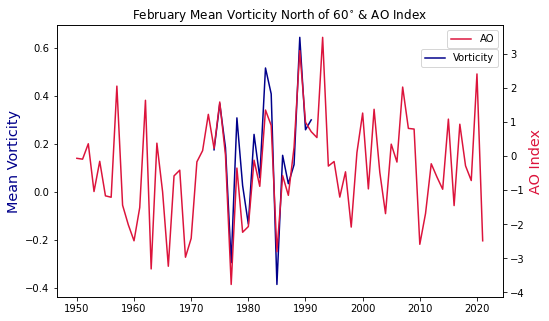

In [80]:
month = 1

years = np.arange(1974,1992)

mean_vorts = []

for year in years:

    d = Dataset(f'/home/robbie/Dropbox/beaufort_sea/vorticity_files/{year}{str(month).zfill(2)}.nc')

    mean_vort = np.nanmean(np.array(d['vort_ave']))

    mean_vorts.append(mean_vort)

ao_month = ao_dat[ao_dat['month']=='01']

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(years,mean_vorts,color='darkblue',label='Vorticity')
ax.set_ylabel('Mean Vorticity', fontsize='x-large',color='darkblue')

ax2 = ax.twinx()
ax2.plot(ao_month['year'],ao_month['Value'],color='crimson',label='AO')

ax2.set_ylabel('AO Index', fontsize='x-large',color='crimson')

ax.set_title(r'February Mean Vorticity North of 60$^{\circ}$ & AO Index')

ax.legend(bbox_to_anchor=(1,0.93))
ax2.legend()

In [22]:
np.array(ao_feb['year'])

array(['1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957',
       '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981',
       '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
      dtype=object)

In [44]:
import mask

In [70]:
lon = mask.get('lon')
lat = mask.get('lat')
m = mask.get('mask')
from importlib import reload
import regrid
from regrid import griddata
import xarray as xr

In [50]:
adata = Dataset('/home/robbie/Dropbox/beaufort_sea/iceage_nh_12.5km_20200101_20210204_ql.nc')
alons = np.array(adata['longitude'])
alats = np.array(adata['latitude'])

In [75]:
ds = xr.Dataset( data_vars={'mask':(['x','y'],x)},

                 coords =  {'lon':(['x','y'],alons),
                            'lat':(['x','y'],alats)})

ds.to_netcdf(f'mask720.nc','w')

In [76]:
d = Dataset('mask720.nc')

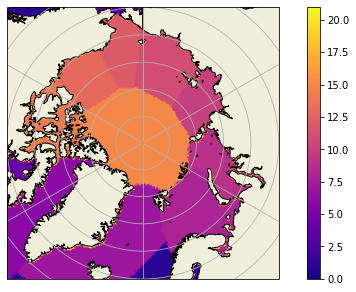

In [79]:
from cartoplot import cartoplot

cartoplot(d['lon'],d['lat'],d['mask'])